In [34]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import math
import librosa
import json
import wave
import sys
import pickle
import sklearn

import urllib.request

import librosa.display
import scipy, matplotlib.pyplot as plt, IPython.display as ipd

from scipy.io import wavfile
from os import listdir
from os.path import isfile, join
import subprocess

import librosa.display
import soundfile as sf

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import os
import matplotlib.style as ms
from tqdm import tqdm
import IPython.display
import random
ms.use('seaborn-muted')
%matplotlib inline

In [2]:
audio_data = "Audio/"
audio_preproccess = 'data/Audio_pre/'
annotations_data_by_emotions = "Annotations_by_emotions/"

df_angry = pd.read_csv(annotations_data_by_emotions + 'data_Angry.csv', index_col='ID')
df_disgusted = pd.read_csv(annotations_data_by_emotions + 'data_Disgusted.csv', index_col='ID')
df_happy = pd.read_csv(annotations_data_by_emotions + 'data_Happy.csv', index_col='ID')
df_neutral = pd.read_csv(annotations_data_by_emotions + 'data_Neutral.csv', index_col='ID')
df_sad = pd.read_csv(annotations_data_by_emotions + 'data_Sad.csv', index_col='ID')
df_scared = pd.read_csv(annotations_data_by_emotions + 'data_Scared.csv', index_col='ID')
df_surprised = pd.read_csv(annotations_data_by_emotions + 'data_Surprised.csv', index_col='ID')

In [3]:
df_angry['Emotion'] = 'ang'
df_disgusted['Emotion'] = 'dis' 
df_happy['Emotion'] = 'hap' 
df_neutral['Emotion'] = 'neu' 
df_sad['Emotion'] = 'sad'
df_scared['Emotion'] = 'sca' 
df_surprised['Emotion'] = 'sur'

In [4]:
df_complete = pd.concat([df_happy, df_angry, df_disgusted, df_neutral, df_sad, df_scared, df_surprised])
df_complete.File += '_mic.wav'

In [5]:
df_complete.head()

,File,Start,End,Emotion
ID,,,,
1,10dec_D11_1_mic.wav,104.750,116.500,hap
1,10dec_D11_1_mic.wav,199.300,210.220,hap
1,10dec_D42_1_mic.wav,27.153,29.440,hap
1,10dec_D52_2_mic.wav,27.470,30.460,hap
1,10dec_D61_1_mic.wav,24.641,26.321,hap


In [6]:
df_complete.to_csv('df_complete.csv', index=False)

In [7]:
labels_df = pd.read_csv('df_complete.csv')

In [8]:
sr = 44100
audio_vectors = {}
metadata_vectors = {}
min = (1000000, '')
for sess in [1]:  # using one session due to memory constraint, can replace [5] with range(1, 6)
    wav_file_path = 'Audio/'
    orig_wav_files = os.listdir(wav_file_path)
    index = 0
    for orig_wav_file in tqdm(orig_wav_files):
        try:
            orig_wav_vector, _sr = librosa.load(wav_file_path + orig_wav_file, sr=sr)
            orig_wav_file, file_format = orig_wav_file.split('.')
            if orig_wav_file == '10dec_O11_1_mic':
                continue
            for i, row in labels_df[labels_df['File'].str.contains(orig_wav_file)].iterrows():
                start_time, end_time, truncated_wav_file_name, emotion = row['Start'], row['End'], row['File'], row['Emotion']
                if end_time - start_time < 1.5:
                    continue
                start_frame = math.floor(np.abs(start_time) * sr)
                end_frame = math.floor(end_time * sr)
                truncated_wav_vector = orig_wav_vector[start_frame:end_frame + 1]
                audio_vectors["{:05d}_".format(index) + truncated_wav_file_name] = (truncated_wav_vector, emotion)
                metadata_vectors["{}_".format(index) + truncated_wav_file_name] = emotion
                index += 1
        except KeyboardInterrupt:
            break
        except:
            print('An exception occured for {}'.format(orig_wav_file))
            raise
#     with open('audio_vectors/audio_vectors_{}.pkl'.format(sess), 'wb') as f:
#         pickle.dump(audio_vectors, f)
# print(min)

100%|██████████| 580/580 [00:11<00:00, 50.08it/s]


In [9]:
len(audio_vectors)

10227

In [10]:
path_preproccess = "Audio_preprocess/"
# sf.write('stereo_file.wav', np.random.randn(10, 2), 44100, 'PCM_24')
files = []
emotions = []
for i in tqdm(audio_vectors):
    files.append(path_preproccess + i)
    emotions.append(audio_vectors[i][1])
    sf.write(path_preproccess + i, audio_vectors[i][0], 44100, 'PCM_24')
preprop_data = {"File": files, "Emotion" : emotions}
df_prep = pd.DataFrame.from_dict(preprop_data)
df_prep.to_csv('df_prep.csv', index=False)

100%|██████████| 10227/10227 [02:44<00:00, 62.36it/s]


In [24]:
ipd.Audio('Audio_preprocess/00785_14dec_D14_2_mic.wav')
# str = input()

In [9]:
labels_df.to_numpy()

array([['10dec_D11_1_mic.wav', 104.75, 116.5, 'hap'],
       ['10dec_D11_1_mic.wav', 199.3, 210.22, 'hap'],
       ['10dec_D42_1_mic.wav', 27.153, 29.44, 'hap'],
       ...,
       ['22dec_K42_1_mic.wav', 25.02, 30.32, 'sur'],
       ['22dec_K43_2_mic.wav', 6.72, 20.27, 'sur'],
       ['22dec_K44_2_mic.wav', 18.227, 23.67, 'sur']], dtype=object)

In [21]:
labels_df = pd.read_csv('df_prep.csv')
# labels_df

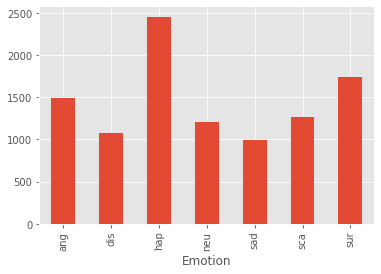

In [26]:
# labels_df.hist(bins=3, column='Emotion')


labels_df.groupby('Emotion').count().plot.bar(legend=False)

plt.show()

In [2]:

mypath = 'Audio_preprocess/'
audio_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [129]:
for i in tqdm(audio_files):
    name = 'Audio_preprocess/' + i
    subprocess.run(['sox', name, '-c', '1', '-b', '16', '-r', '48000', name], stdout=subprocess.PIPE)

100%|██████████| 10227/10227 [02:42<00:00, 62.75it/s]


In [3]:
for i in tqdm(audio_files):
    name = 'Audio_ogg_10/' + i[:-4] + '.ogg'
    subprocess.run(['oggenc', '-q', '10', '-o',  name, mypath + i], stdout=subprocess.PIPE)

100%|██████████| 10227/10227 [19:45<00:00,  8.63it/s] 


In [94]:
result = subprocess.run(['yc', 'iam', 'create-token'], stdout=subprocess.PIPE)

In [95]:
token = result.stdout.decode('utf-8')
token = token[:-1]

In [3]:
import urllib.request
import json

# hertz 48000 for en lang 16000 for ru lang
def recognize_text(name, aim_token, folder_id = "b1gt00uvl895f9u47f90", hertz=16000, lang="ru"):
    
    FOLDER_ID = folder_id # Идентификатор каталога
    IAM_TOKEN = aim_token
    with open("{}".format(name), "rb") as f:
        data = f.read()
    
    if lang == "ru":
        lg = "ru-RU"
    elif lang == "en":
        lg = "en-US"
    params = "&".join([
        "topic=general",
        "folderId=%s" % FOLDER_ID,
#         "format=lpcm",
        "sampleRateHertz={}".format(hertz),
        "lang=" + lg
    ])

    url = urllib.request.Request("https://stt.api.cloud.yandex.net/speech/v1/stt:recognize?%s" % params, data=data)
    url.add_header("Authorization", "Bearer %s" % IAM_TOKEN)

    responseData = urllib.request.urlopen(url).read().decode('UTF-8')
    decodedData = json.loads(responseData)
#     print(responseData)
    
    if decodedData.get("error_code") is None:
        return decodedData.get("result")
    else:
        return decodeData

In [97]:
text = recognize_text("output.ogg", token, hertz=48000, lang="ru")
print("Recognized: ", text)

Recognized:  


In [127]:
ipd.Audio(y2, rate=sr1)

In [125]:
# y, sr = librosa.load("speech.ogg")
y1, sr1 = librosa.load("00785_14dec_D14_2_mic.wav", sr=48000)
y2, sr2 = librosa.load("outputTest.wav", sr=48000)

In [126]:
print(y2, sr2)

[ 0.00042725 -0.00076294 -0.0032959  ... -0.00421143 -0.00482178
 -0.00308228] 48000


In [102]:
print(y, sr)

[-8.3163031e-06 -3.2572356e-05 -2.9655190e-05 ...  3.6761639e-06
 -2.9266123e-05  0.0000000e+00] 22050


In [120]:
print(y1, sr1)

[ 0.00043279 -0.00077154 -0.00330143 ... -0.00423872 -0.00483358
  0.        ] 48000


In [4]:
import logging

logger = logging.getLogger('http_errors')
logger.setLevel(logging.INFO)
fh = logging.FileHandler('error.log')
fh.setLevel(logging.ERROR)
logger.addHandler(fh)

In [66]:
# logger.error('creating an instance of auxiliary_module.Auxiliary' + 'asrt')

In [10]:
def audiosToText(filesPath, token, logger, sttFunc, audioToText = None):
    if audioToText is None:
        audioToText = {}

    files = [f for f in listdir(filesPath) if isfile(join(filesPath, f))]
    try:
        for i in tqdm(files):
            if audioToText[i[:-4]] != '' and audioToText[i[:-4]] != None:
                continue
            size = os.path.getsize(filesPath + i)
            if size > 2**20:
                text = ""
            else:
                try:
                    text = sttFunc(filesPath + i, token, lang="ru")
                except urllib.error.HTTPError as exception:
#                     print(i, exception)
                    logger.error(i + ' ' + str(exception))
                    continue
                except:
                    raise
#             if i[:-4] in audioToText:
#                 continue
            if text is None or text == '':
                logger.error(i)
                text = ''
            audioToText[i[:-4]] = text
    except Exception as error:
        print('An exception occurred: {}'.format(error))
        return audioToText
    return audioToText

In [21]:
result = subprocess.run(['yc', 'iam', 'create-token'], stdout=subprocess.PIPE)
token = result.stdout.decode('utf-8')
token = token[:-1]

In [6]:
oggFiles = 'Audio_ogg/'
if os.path.exists('text.csv'):
    speechToText = pd.read_csv('text.csv', index_col='File').fillna("")
    speechToText = speechToText.to_dict()['Text']
else:
    speechToText = {}
    filesPath = 'Audio_ogg/'
    ogg_files = [f for f in listdir(filesPath) if isfile(join(filesPath, f))]
    for i in tqdm(ogg_files):
        text = ""
        speechToText[i[:-4]] = text
# speechToText = audiosToText(oggFiles, token, logger, recognize_text, speechToText)

In [130]:
os.path.exists('text.csv')

True

In [8]:
# speechToText

In [44]:
prepared_dict = {i: x for i, x in enumerate(speechToText.items())}
df_text = pd.DataFrame.from_dict(prepared_dict, orient='index', columns=['File', 'Text'])
df_text.to_csv('text.csv', header=['File', 'Text'], index=False)

In [26]:
from google.cloud import speech_v1
from google.cloud.speech_v1 import enums
# from google.cloud import speech_v1p1beta1
# from google.cloud.speech_v1p1beta1 import enums
import io


def google_recognize(local_file_path, token, lang, hertz=48000):
    """
    Transcribe a short audio file using synchronous speech recognition

    Args:
      local_file_path Path to local audio file, e.g. /path/audio.wav
    """

    client = speech_v1.SpeechClient()

    # local_file_path = 'resources/brooklyn_bridge.raw'

    # The language of the supplied audio
    language_code = "ru-RU"

    # Sample rate in Hertz of the audio data sent
    sample_rate_hertz = hertz

    # Encoding of audio data sent. This sample sets this explicitly.
    # This field is optional for FLAC and WAV audio formats.
    encoding = enums.RecognitionConfig.AudioEncoding.LINEAR16
    config = {
        "language_code": language_code,
        "sample_rate_hertz": sample_rate_hertz,
        "encoding": encoding,
    }
    with io.open(local_file_path, "rb") as f:
        content = f.read()
    audio = {"content": content}

    response = client.recognize(config, audio)
    for result in response.results:
        # First alternative is the most probable result
        alternative = result.alternatives[0]
#         print(u"Transcript: {}".format(alternative.transcript))
        return alternative.transcript
    return ''

In [28]:
google_recognize('outputTest.wav', None, 'ru', hertz=48000)

'я домой квадроциклах'

In [20]:
print('Credendtials from environ: {}'.format(os.environ.get('GOOGLE_APPLICATION_CREDENTIALS')))

Credendtials from environ: /home/olegs/Downloads/MyFirstProject-8a03f78c3f6a.json


In [15]:
speechToText = audiosToText(mypath, None, logger, google_recognize, speechToText)

 17%|█▋        | 1707/10227 [09:03<1:56:08,  1.22it/s] 

An exception occurred: [Errno 24] Too many open files: '/home/olegs/Downloads/MyFirstProject-8a03f78c3f6a.json'


In [41]:
# speechToText['10216_22dec_D22_2_mic'] = ''

In [16]:
df = pd.read_csv('df_prep.csv').to_numpy()

In [21]:
meta_data = {}
for i in df:
    path = i[0]
    emo = i[1]
    meta_data[path[path.find('/')+1:-4]] = emo

In [27]:
preprop_data = {"File": list(meta_data.keys()), "Emotion" : list(meta_data.values())}
df_prep = pd.DataFrame.from_dict(preprop_data)
df_prep.to_csv('df_prep.csv', index=False)

In [19]:
meta = pd.read_csv('df_prep.csv')
text = pd.read_csv('text.csv').fillna(' ')

In [25]:
files = []
emotions = []
texts = []
emotionToSent = {
    'ang': 0,
    'dis': 0,
    'hap': 1,
    'sad': 0,
    'sca': 0,
    'sur': 1,
    'neu': 2
}
for i in meta.to_numpy():
    files.append(i[0])
    emotions.append(emotionToSent[i[1]])
    texts.append(text.loc[text['File'] == i[0]].Text.values[0])

In [26]:
preprop = {"File": files, "Text" : texts , "Emotion" : emotions}
df_prep = pd.DataFrame.from_dict(preprop)
df_prep.to_csv('meta_text.csv', index=False)

In [27]:
meta_all = pd.read_csv('meta_text.csv')

In [29]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(meta_all, test_size=0.3)

In [31]:
train.to_csv('train_text.csv', index=False)
test.to_csv('test_text.csv', index=False)

In [ ]:
# wav_vector, _sr = librosa.load(file_path, sr=self.sr)
# feature_vector = librosa.feature.melspectrogram(y=wav_vector, sr=_sr)

import os
import matplotlib
matplotlib.use('Agg') # No pictures displayed 
import pylab
import librosa
import librosa.display
import numpy as np

sig, fs = librosa.load('00785_14dec_D14_2_mic.ogg')   
# make pictures name 
save_path = 'test.png'

pylab.axis('off') # no axis
pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
S = librosa.feature.melspectrogram(y=sig, sr=fs)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
pylab.close()

In [35]:
mypath = 'Audio_preprocess/'
audio_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [36]:
for i in audio_files:
    file = mypath + i
    sig, fs = librosa.load(file)   
    # make pictures name 
    save_path = 'Images/' +

    pylab.axis('off') # no axis
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
    S = librosa.feature.melspectrogram(y=sig, sr=fs)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
    pylab.close()

09365_22dec_K54_1_mic.wav
03067_15dec_D62_2_mic.wav
05911_15dec_K32_1_mic.wav
07617_19dec_D23_2_mic.wav
06138_15dec_D53_2_mic.wav
00382_16dec_K63_2_mic.wav
07127_15dec_K61_2_mic.wav
03190_10dec_K31_1_mic.wav
07001_19dec_D12_2_mic.wav
05606_19dec_K41_2_mic.wav
02863_22dec_K63_1_mic.wav
07355_15dec_K31_1_mic.wav
04332_19dec_D51_2_mic.wav
01646_16dec_D12_2_mic.wav
08297_10dec_D52_1_mic.wav
05473_19dec_D53_1_mic.wav
05479_19dec_D53_1_mic.wav
03292_16dec_D43_2_mic.wav
00771_15dec_K45_1_mic.wav
03952_22dec_D72_1_mic.wav
00654_10dec_D11_1_mic.wav
02180_10dec_N11_2_mic.wav
09336_19dec_K51_1_mic.wav
06527_15dec_K23_1_mic.wav
07155_19dec_K61_2_mic.wav
05407_14dec_D41_2_mic.wav
10209_22dec_D22_2_mic.wav
05069_16dec_D14_1_mic.wav
06604_15dec_K23_2_mic.wav
02555_10dec_K41_1_mic.wav
01961_19dec_K32_2_mic.wav
09592_15dec_K33_1_mic.wav
04468_22dec_D12_2_mic.wav
07158_19dec_K61_2_mic.wav
01119_22dec_K44_2_mic.wav
05899_15dec_K32_1_mic.wav
06857_16dec_D42_2_mic.wav
02463_14dec_D21_1_mic.wav
04287_10dec_